Adapted in notebook time_series_gp_s+l_pulse_kernel_step_by_step:
- Use data file sim_pulse.lc
- Find the best kernel mixture for the stellar oscillations, step by step

In [1]:
import os
import sys
import math
%load_ext autoreload
%autoreload 2

import numpy as np
np.random.seed(0)

# Plotting tools
from matplotlib import pyplot as plt
# we use the following for plotting figures in jupyter
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from astropy.timeseries import LombScargle
from spleaf import cov, term
from scipy.optimize import fmin_l_bfgs_b

import pandas as pd
pd.set_option('precision', 0)
pd.set_option('display.float_format', lambda x: '%.16f' % x)

# Start the notebook from the root of the project
if 'notebooks' in os.getcwd():
    os.chdir(os.path.dirname(os.getcwd()))
    if os.getcwd().endswith('notebooks'):
        os.chdir(os.path.dirname(os.getcwd()))

 # Local imports (i.e., my code) from the src folder
sys.path.insert(0, os.path.join(os.getcwd(), 'src'))

import experiment_util
from plot_helpers import *
plotter = PlotUtilSPLeaf()

In [2]:
# Make the notebook use the whole screen width
from IPython.display import display, HTML

display(HTML(data="""
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))

Read the first time series

In [3]:
df = pd.read_csv("data/sim_pulse.lc",sep=' ', header = None, names=['Time', 'Lc'], index_col=False, float_precision='round_trip')

In [4]:
X, Y = df['Time'].tolist(), df['Lc'].tolist()
X, Y = np.array(X), np.array(Y)

# 1. Exploratory
## Zoomed in on the first N observations

In [5]:
# This library becomes unstable at N=15125
# N=15125
N=X.shape[0]
N_part=11300

In [6]:
X_part=X[:N_part]
Y_part=Y[:N_part]

In [7]:
# Don't normalize here, as the data is already mean centered and we have included the RMSE
# numbers already in the paper.
# _, _, Y_part = experiment_util.normalize_mean(Y_part)
# Add random uncorrelated noise to the data
N_part, Y_part = experiment_util.generate_random_noise(Y_part)

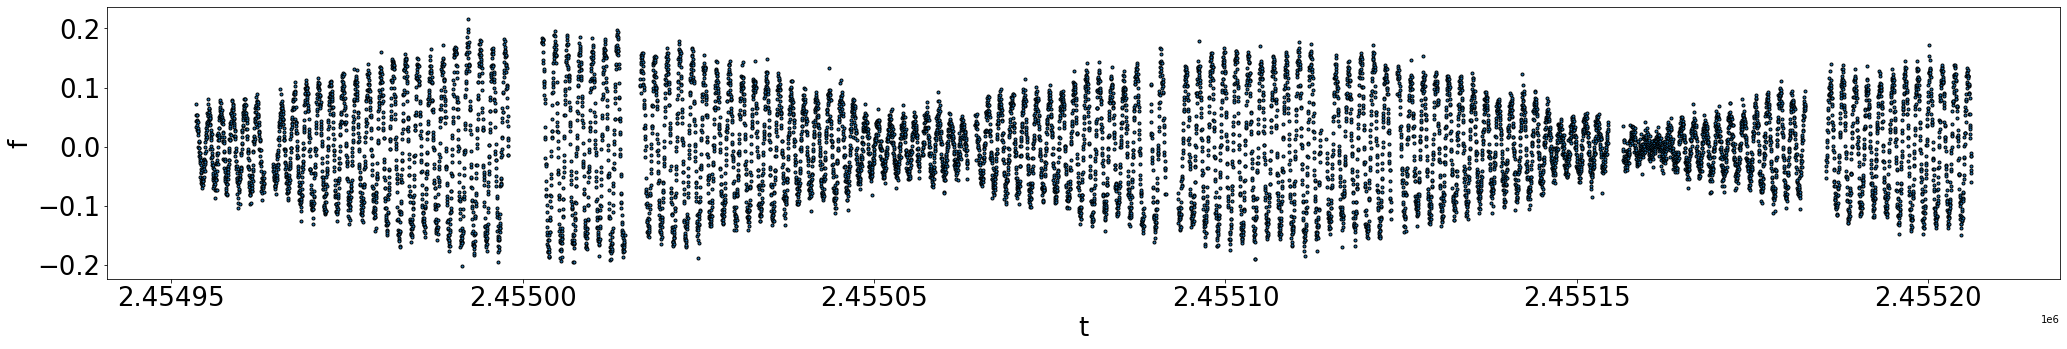

In [8]:
plotter.plot_data(X_part, Y_part)

# 2. Processing


Compose a Gaussian Process from a reasonable guess of kernels

array([0.56720233, 0.56733834, 0.56706631, 0.56747435, 0.5669303 ,
       0.56761036, 0.5575455 , 0.55740949, 0.55768151, 0.55727348])

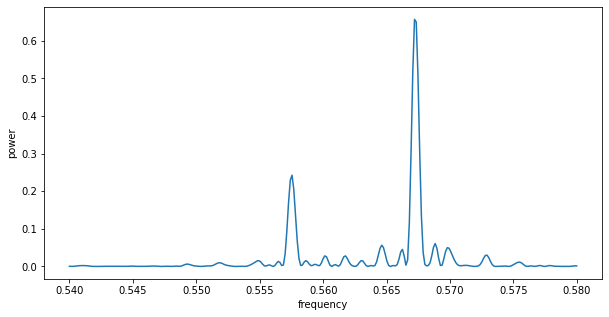

In [9]:
frequencies, power = LombScargle(X, Y).autopower(minimum_frequency=0.54, maximum_frequency=0.58)
plt.figure(figsize=(10, 5))
plt.plot(frequencies, power)
plt.xlabel("frequency"), plt.ylabel("power")
frequencies[np.argsort(power)[::-1][:10]]

In [10]:
# Define the function to minimize
def negloglike(x, y, cov_matrix, params_to_fit):
   cov_matrix.set_param(x, params_to_fit)
   nll = -cov_matrix.loglike(y)
   # gradient
   nll_grad = -cov_matrix.loglike_grad()[1]
   return(nll, nll_grad)

In [11]:
# Initialize the S+LEAF model with one term
cov_matrix = cov.Cov(X_part,
   sho = term.SHOKernel(sig=-0.056267, P0=1/0.5673, Q=8000.36505))

In [12]:
# List of parameters to fit: fit sigma only, we pre-set the undamped period and Q
params_to_fit = cov_matrix.param[:1]

# We now fit the hyperparameters using the fmin_l_bfgs_b function from scipy.optimize.
xbest,_,_ = fmin_l_bfgs_b(negloglike, cov_matrix.get_param(), args=(Y_part, cov_matrix, params_to_fit))

In [13]:
# We now use S+LEAF to predict the missing data on the training data scope
cov_matrix.set_param(xbest, params_to_fit)
Y_part_pred, var_part = cov_matrix.conditional(Y_part, X_part, calc_cov='diag')

In [14]:
plotter.plot_series(X_part, Y_part, X_part, Y_part_pred, var_part)

## Explore the parameters of the fitted model

In [15]:
cov_matrix.param

['sho.sig', 'sho.P0', 'sho.Q']

In [16]:
cov_matrix.get_param('sho.sig'), cov_matrix.get_param('sho.P0'), cov_matrix.get_param('sho.Q')

(-7.239253304831009, 1.7627357659086902, 8000.36505)

## Model Evaluation

In [17]:
# Fit the model on the original X timestamps
# Y_part_pred, var_part = cov_matrix.conditional(Y_part, X_part, calc_cov='diag')
experiment_util.calculate_error(Y_part, Y_part_pred)

TimeSeriesSimilarity(correlation=0.9999999999999916, rmse=1.2638478450819997e-08)

In [18]:
# plotter.plot_series(X_part, Y_part, X_part, Y_part_pred, var_part)

# Residuals
Calculate the residuals after fitting the model for our next step.

In [19]:
resid1_part = Y_part - Y_part_pred

Y_part, Y_part_pred, resid1_part

In [20]:
plotter.plot_series(X_part, resid1_part)

## Stage 2: Model the residuals

In [21]:
# Initialize the S+LEAF model
cov_matrix2 = cov.Cov(X_part,
   sho1 = term.SHOKernel(sig=-0.056267, P0=1/0.5673, Q=8000.36505),
   sho2 = term.SHOKernel(sig=-0.0000000004314, P0=1/0.5575, Q=200000.36505))

In [22]:
cov_matrix2.param

['sho1.sig', 'sho1.P0', 'sho1.Q', 'sho2.sig', 'sho2.P0', 'sho2.Q']

In [23]:
# List of parameters to fit: fit sigma only, we pre-set the undamped period and Q
params_to_fit = ['sho1.sig', 'sho2.sig']
# We now fit the hyperparameters using the fmin_l_bfgs_b function from scipy.optimize.
xbest_res2,_,_ = fmin_l_bfgs_b(negloglike, cov_matrix2.get_param(), args=(Y_part, cov_matrix2, params_to_fit))
cov_matrix2.set_param(xbest_res2, params_to_fit)

In [24]:
# We now use S+LEAF to predict the missing data on the training data scope
cov_matrix2.set_param(xbest, params_to_fit)
Y_part_pred, var_part = cov_matrix2.conditional(Y_part, X_part, calc_cov='diag')

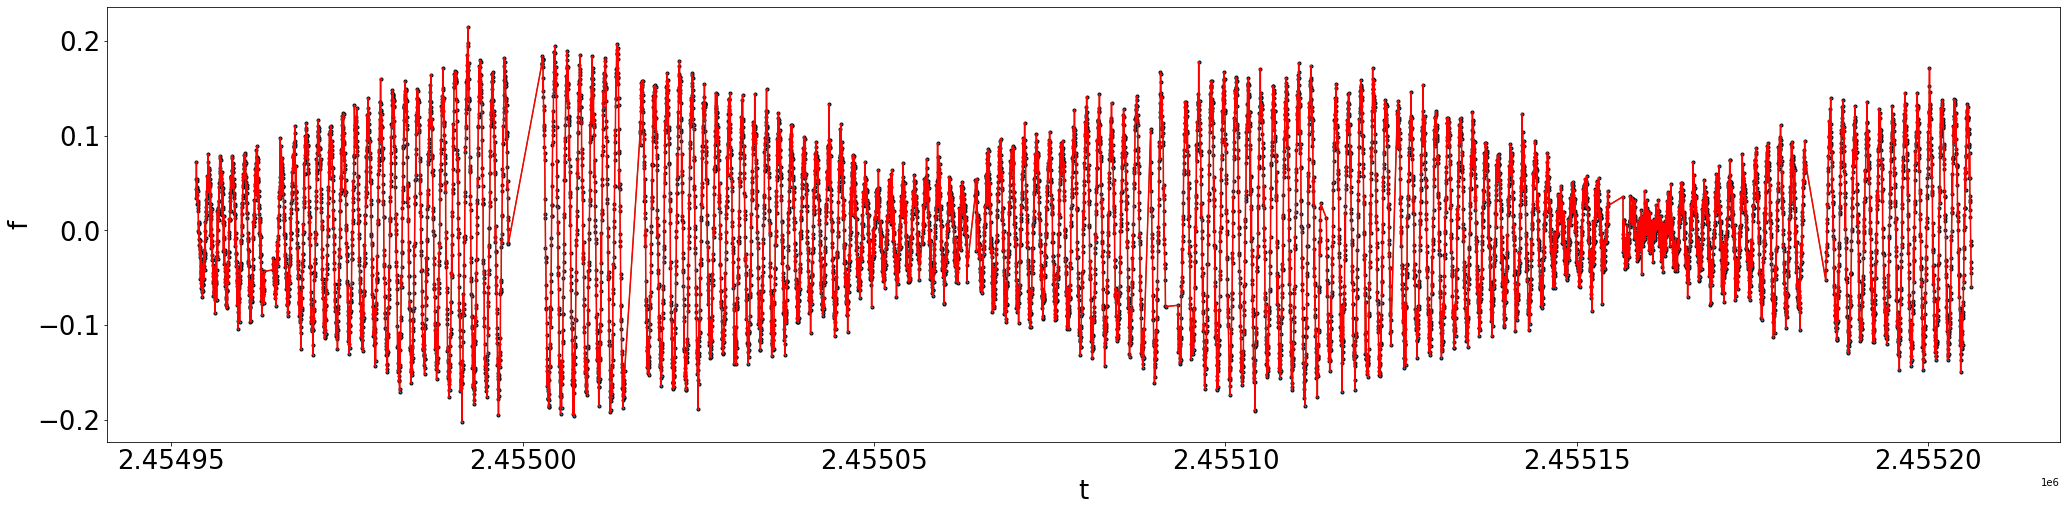

In [25]:
plotter.plot_series(X_part, Y_part, X_part, Y_part_pred, var_part)

In [26]:
# mu_res2_part, _ = cov_matrix2.conditional(Y_part, X_part, calc_cov='diag')
# resid2_part = Y_part - mu_res2_part
# Y_part, mu_res2_part, resid2_part
experiment_util.calculate_error(Y_part, Y_part_pred)

TimeSeriesSimilarity(correlation=0.9999999999913892, rmse=3.709707223452469e-07)

In [27]:
# plotter.plot_series(X_part, resid2_part)

## Stage 3: Model the pulsation signal with 3 terms

In [28]:
# Initialize the S+LEAF model
cov_matrix3 = cov.Cov(X_part,
   sho1 = term.SHOKernel(sig=-0.056267, P0=1/0.5673, Q=8000.36505),
   sho2 = term.SHOKernel(sig=-0.0000000004314, P0=1/0.5575, Q=200000.36505),
   sho3 = term.SHOKernel(sig=-0.0000000000000000004314, P0=1/0.5685, Q=200000.36505))

In [29]:
# List of parameters to fit: fit sigma only, we pre-set the undamped period and Q
params_to_fit = ['sho1.sig', 'sho2.sig', 'sho3.sig']
# We now fit the hyperparameters using the fmin_l_bfgs_b function from scipy.optimize.
xbest_res3,_,_ = fmin_l_bfgs_b(negloglike, cov_matrix3.get_param(), args=(Y_part, cov_matrix3, params_to_fit))
cov_matrix3.set_param(xbest_res3, params_to_fit)

In [30]:
# We now use S+LEAF to predict the missing data on the training data scope
Y_part_pred, var_part = cov_matrix3.conditional(Y_part, X_part, calc_cov='diag')
experiment_util.calculate_error(Y_part, Y_part_pred)

TimeSeriesSimilarity(correlation=0.9999999999929067, rmse=3.61044720761562e-07)

In [31]:
plotter.plot_series(X_part, Y_part, X_part, Y_part_pred, var_part)

## Stage 4: Model the residuals

In [32]:
# Initialize the S+LEAF model
cov_matrix4 = cov.Cov(X_part,
   sho1 = term.SHOKernel(sig=-0.056267, P0=1/0.5673, Q=8000.36505),
   sho2 = term.SHOKernel(sig=-0.0000000004314, P0=1/0.5575, Q=200000.36505),
   sho3 = term.SHOKernel(sig=-0.0000000000000000004314, P0=1/0.5685, Q=200000.36505),
   sho4 = term.SHOKernel(sig=-0.0000000000000000004314, P0=1/0.6594, Q=200000.36505))

In [33]:
# List of parameters to fit: fit sigma only, we pre-set the undamped period and Q
params_to_fit = ['sho1.sig', 'sho2.sig', 'sho3.sig', 'sho4.sig']

# We now fit the hyperparameters using the fmin_l_bfgs_b function from scipy.optimize.
xbest_res4,_,_ = fmin_l_bfgs_b(negloglike, cov_matrix4.get_param(), args=(Y_part, cov_matrix4, params_to_fit))
cov_matrix4.set_param(xbest_res4, params_to_fit)

In [34]:
# We now use S+LEAF to predict the missing data on the training data scope
Y_part_pred, var_part = cov_matrix4.conditional(Y_part, X_part, calc_cov='diag')
experiment_util.calculate_error(Y_part, Y_part_pred)

TimeSeriesSimilarity(correlation=0.9999999999929067, rmse=3.6104472076156185e-07)

In [35]:
plotter.plot_series(X_part, Y_part, X_part, Y_part_pred, var_part)

## Stage 5 Model the residuals

In [36]:
# Initialize the S+LEAF model
cov_matrix5 = cov.Cov(X_part,
   sho1 = term.SHOKernel(sig=-0.056267, P0=1/0.5673, Q=8000.36505),
   sho2 = term.SHOKernel(sig=-0.0000000004314, P0=1/0.5575, Q=200000.36505),
   sho3 = term.SHOKernel(sig=-0.0000000000000000004314, P0=1/0.5685, Q=200000.36505),
   sho4 = term.SHOKernel(sig=-0.0000000000000000004314, P0=1/0.6594, Q=200000.36505),
   sho5 = term.SHOKernel(sig=-0.0000000000000000004314, P0=1/0.4348, Q=200000.36505))

In [37]:
# List of parameters to fit: fit sigma only, we pre-set the undamped period and Q
params_to_fit = ['sho1.sig', 'sho2.sig', 'sho3.sig', 'sho4.sig', 'sho5.sig']

# We now fit the hyperparameters using the fmin_l_bfgs_b function from scipy.optimize.
xbest_res5,_,_ = fmin_l_bfgs_b(negloglike, cov_matrix5.get_param(), args=(Y_part, cov_matrix5, params_to_fit))
cov_matrix5.set_param(xbest_res5, params_to_fit)

In [38]:
# We now use S+LEAF to predict the missing data on the training data scope
Y_part_pred, var_part = cov_matrix5.conditional(Y_part, X_part, calc_cov='diag')
experiment_util.calculate_error(Y_part, Y_part_pred)

TimeSeriesSimilarity(correlation=0.9999999999782293, rmse=5.761405254123007e-07)

In [39]:
plotter.plot_series(X_part, Y_part, X_part, Y_part_pred, var_part)